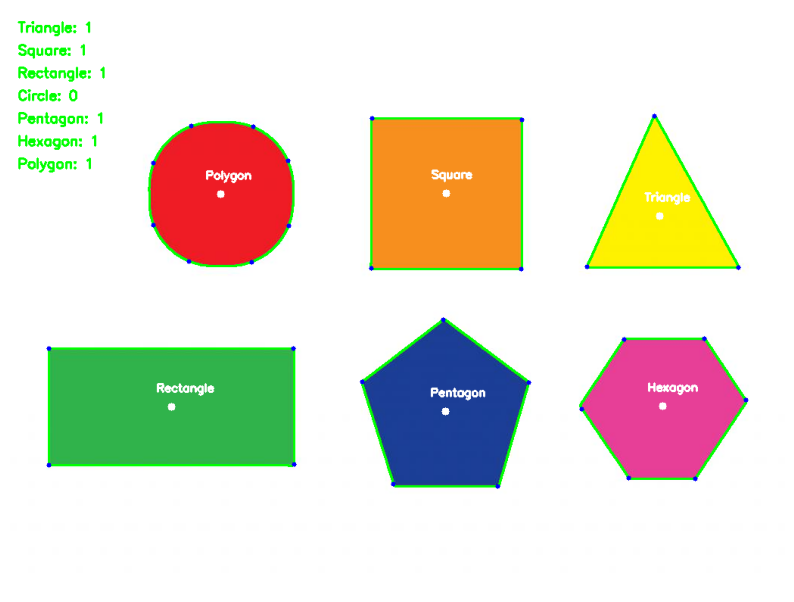

Detected shapes count:
Triangle: 1
Square: 1
Rectangle: 1
Circle: 0
Pentagon: 1
Hexagon: 1
Polygon: 1



In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_shapes(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or the path is incorrect")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)

        # If the shape has 3 vertices, it's a triangle
        if len(approx) == 3:
            shapes.append((contour, "Triangle", approx))
        # If the shape has 4 vertices, it's either a square or a rectangle
        elif len(approx) == 4:
            # Calculate aspect ratio
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            # If aspect ratio is close to 1, it's a square, otherwise a rectangle
            shape_type = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
            shapes.append((contour, shape_type, approx))
        # If the shape has 5 vertices, it's a pentagon
        elif len(approx) == 5:
            shapes.append((contour, "Pentagon", approx))
        # If the shape has 6 vertices, it's a hexagon
        elif len(approx) == 6:
            shapes.append((contour, "Hexagon", approx))
        # If the shape has more than 6 vertices, it could be a circle or polygon
        else:
            # Use a simple heuristic: if the shape is very close to a circle
            area = cv2.contourArea(contour)
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circle_area = np.pi * (radius ** 2)
            # Consider it a circle if the area difference is small and vertices are more than 8
            if abs(circle_area - area) < 0.5 * circle_area and len(approx) > 8:
                shapes.append((contour, "Circle", approx))
            else:
                shapes.append((contour, "Polygon", approx))

    return shapes, image

if __name__ == "__main__":
    image_path = "shape.jpg"  # Path to your image
    detected_shapes, image = detect_shapes(image_path)

    # Count shapes
    shape_counts = {"Triangle": 0, "Square": 0, "Rectangle": 0, "Circle": 0, "Pentagon": 0, "Hexagon": 0, "Polygon": 0}
    for contour, shape, _ in detected_shapes:
        shape_counts[shape] += 1

    # Annotate and mark the shapes
    for i, (contour, shape, vertices) in enumerate(detected_shapes):
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the contour
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        
        # Draw a mark at each vertex
        for vertex in vertices:
            x, y = vertex.ravel()
            cv2.circle(image, (x, y), 3, (255, 0, 0), -1)
        
        # Draw a mark at the centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(image, (cX, cY), 5, (255, 255, 255), -1)
            
            # Draw the name of the shape at the centroid
            cv2.putText(image, shape, (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    # Print the counts of each shape
    shape_count_text = "Detected shapes count:\n"
    y0, dy = 30, 30
    for i, (shape, count) in enumerate(shape_counts.items()):
        text = f"{shape}: {count}"
        shape_count_text += text + "\n"
        cv2.putText(image, text, (10, y0 + i * dy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display the annotated image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Display the shape count text
    print(shape_count_text)
